## Datos de entrada

El set de datos seleccionado consta de las construcciones en Costa Rica realizadas por el sector privado extraido por medio de una encuesta anual que se realiza por el Instituo Nacional de Estadísticas y Censo (INEC) desde el año 2002 hasta el año 2018 con excepción del año 2008 que no se realizó esta encuesta.

Nombre | Etiqueta | Pregunta | Tipo de dato
--- | --- | --- | ---
anoper | Año del permiso | Fecha (año): | Numérico
num_obras | Número de obras | Indique Nº de obras:  | Numérico
arecon | Area de construcción | Área de construcción (metros cuadrados m2)  | Numérico
valobr | Valor de la obra | Valor de la obra (Colones):  | Numérico
claper | Clase del permiso | Permiso para:  | Categórico
claobr | Clase de la obra | Clase de obra: | Categórico
numpis | Número de pisos | Número de pisos | Numérico
numviv | Número de viviendas | Nº de viviendas (incluye apartamentos). | Numérico
numapo | Número de aposentos | Nº total de aposentos | Numérico
numdor | Número de dormitorios | Nº de aposentos usados como dormitorios | Numérico
matpis | Material de piso | Materiales predominantes. Pisos: | Categórico
matpar | Material de pared | Materiales predominantes. Paredes: | Categórico
mattec | Material de techo | Materiales predominantes. Techos: | Categórico
usoobr | Uso de la obra | La construcción de la obra será para: | Categórico
financ | Financiamiento | Financiamiento (Marque únicamente el de mayor aporte): | Categórico
cod_provincia | Codigo Provincia | Codigo Provincia | Categórico
provincia | Nombre Provincia | Nombre Provincia | Texto (se ingora)
id_canton | Codigo Canton | Codigo Canton | Categórico (se ignora)
canton | Nombre Canton | Nombre Canton | Texto (se ignora)
id_region | Codigo Region | Codigo Region | Categórico
cat | Categoría | **Valor de predicción** | Categórico binario. 


Todos estas columnas menos la columna *id_region* son tomados de la encuesta realizada por el INEC. La columna *id_region* es calculada utilizando la siguente [referencia](https://es.wikipedia.org/wiki/Regiones_socioecon%C3%B3micas_de_Costa_Rica).


In [79]:
## IMPORTANTE - Variables locales. Modificar

spark_home_location = '/usr/local/Cellar/apache-spark/2.4.4/libexec/'
database_name = 'postgres'
database_user_name = 'mario'
database_password = ''
database_table = 'tarea3'

## Preprocesamiento de datos

In [113]:
import findspark
import pandas as pd
import matplotlib.pyplot as plt

findspark.init(spark_home_location)

from pyspark.sql.types import (StringType, LongType, BinaryType, StructField, StructType)

from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("Basic JDBC pipeline") \
    .config("spark.driver.extraClassPath", "postgresql-42.1.4.jar") \
    .config("spark.executor.extraClassPath", "postgresql-42.1.4.jar") \
    .getOrCreate()

construction_df = spark \
    .read \
    .format("csv") \
    .option("path", "construction_data.csv") \
    .option("header", True) \
    .schema(StructType([
                StructField("anoper", StringType()),
                StructField("num_obras", LongType()),
                StructField("arecon", LongType()),
                StructField("valobr", LongType()),
                StructField("claper", LongType()),
                StructField("claobr", LongType()),
                StructField("numpis", LongType()),
                StructField("numviv", LongType()),
                StructField("numapo", LongType()),
                StructField("numdor", LongType()),
                StructField("matpis", LongType()),
                StructField("matpar", LongType()),
                StructField("mattec", LongType()),
                StructField("usoobr", LongType()),
                StructField("financ", LongType()),
                StructField("cod_provincia", LongType()),
                StructField("provincia", StringType()),
                StructField("id_canton", LongType()),
                StructField("canton", StringType()),
                StructField("id_region", LongType()),
                StructField("cat", LongType())])) \
    .load()

columns_kept = ['num_obras', 'arecon', 'numpis', 'numdor',
                'id_region', 'financ', 'matpis', 'matpar', 'cat']
construction_df = construction_df.select(columns_kept)

construction_df.show()

+---------+------+------+------+---------+------+------+------+---+
|num_obras|arecon|numpis|numdor|id_region|financ|matpis|matpar|cat|
+---------+------+------+------+---------+------+------+------+---+
|        1|  4585|    10|    64|        1|     1|    33|     1|  1|
|        1|   323|     2|     4|        1|    99|    22|     1|  1|
|        2|   162|     1|     2|        1|    99|    22|     1|  1|
|        1|   763|     2|     5|        1|    99|    34|     1|  1|
|        1|   212|     2|     3|        1|    99|    22|    27|  1|
|        1|    42|     1|     2|        1|    99|     7|     8|  0|
|        1|   103|     1|     3|        1|    99|    22|     1|  1|
|        1|    46|     1|     2|        1|    99|     7|     8|  0|
|        1|    42|     1|     2|        1|    99|     7|     8|  0|
|        1|    42|     1|     2|        1|     6|     7|     8|  0|
|        1|    42|     1|     2|        1|     6|     7|     8|  0|
|        1|    42|     1|     2|        1|     6

## Guardar en base de datos

In [114]:
construction_df \
    .write \
    .format("jdbc") \
    .mode('overwrite') \
    .option("url", "jdbc:postgresql://localhost/" + database_name) \
    .option("user", database_user_name) \
    .option("password", database_password) \
    .option("dbtable", database_table) \
    .save()

## Estandarización

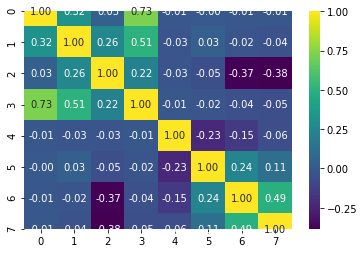

In [115]:
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
import seaborn as sns
import matplotlib.pyplot as plt


# read the data
construction_df = spark \
    .read \
    .format("jdbc") \
    .option("url", "jdbc:postgresql://localhost/" + database_name) \
    .option("user", database_user_name) \
    .option("password", database_password) \
    .option("dbtable", database_table) \
    .load()

# create the vector assembler and standarize the dataset
assembler = VectorAssembler(
    inputCols=['num_obras', 'arecon', 'numpis', 'numdor',
               'id_region', 'financ', 'matpis', 'matpar'],
    outputCol='features')

vector_df = assembler.transform(construction_df)
vector_df = vector_df.select(['features', 'cat'])

standard_scaler = StandardScaler(inputCol='features', outputCol='features_scaled')
scale_model = standard_scaler.fit(vector_df)
construction_scaled_df = scale_model.transform(vector_df).select('features_scaled', 'cat')

# run the correlation
pearson_matrix = Correlation.corr(construction_scaled_df, 'features_scaled').collect()[0][0]
sns.heatmap(pearson_matrix.toArray(), annot=True, fmt=".2f", cmap='viridis')

In [122]:
from pyspark.sql.functions import row_number, col
from pyspark.sql.window import Window
from pyspark.ml.regression import LinearRegression

# Split test and train
train_df, test_df = construction_scaled_df.randomSplit([0.9, 0.1])

# This trick is to add a unique incremental rownumber
split_df = train_df.withColumn('col',lit('ABC'))
split_df = split_df.withColumn("row_num", row_number() \
                   .over(Window().partitionBy('col').orderBy('col'))) \
                   .drop('col')

# Split the dataset into k groups
k = 9
group_size = int(df.count() / k)

group_dfs = []
for group_index in range(k):
    min_row_num = group_index * group_size
    max_row_num = (group_index + 1) * group_size
    filter_expression = 'row_num >= {0} and row_num < {1}'.format(min_row_num, max_row_num)
    group_dfs.append(split_df.filter(filter_expression))
    

for i in range(k):
    df_cross_val_train = spark.createDataFrame(spark.sparkContext.emptyRDD(), split_df.schema)
    df_cross_val_test = spark.createDataFrame(spark.sparkContext.emptyRDD(), split_df.schema)
    for j in range(k):
        if i == j:
            df_cross_val_test = df_cross_val_test.union(group_dfs[j])
        else:
            df_cross_val_train = df_cross_val_train.union(group_dfs[j])    

    regression = LinearRegression(featuresCol='features_scaled', labelCol='cat')
    regression_model = regression.fit(scaled_df)
    
    print('RMSE: ' + str(regression_model.summary.rootMeanSquaredError))
    print('R2: ' + str(regression_model.summary.r2))

    


RMSE: 0.4315811918621775
R2: 0.18826994139665598
RMSE: 0.43158119186217764
R2: 0.18826994139665576
RMSE: 0.43158119186217764
R2: 0.18826994139665576
RMSE: 0.4315811918621775
R2: 0.18826994139665598


KeyboardInterrupt: 